# Acknowledgements 
This notebook lab has been taken from the TBMI26 course (Neural networks and learning systems).

Examiner: Magnus Borga

Initial code authors (MATLAB version): UNKNOWN

Conversion to Python and overall refinement: Martin Hultman & David Abramian

### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [32]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from matplotlib import pyplot as plt
import numpy as np

from utils import loadDataset, splitData, plotProgress, plotProgressNetworkMulti, \
    plotResultsDots, plotIsolines, plotConfusionMatrixOCR, plotResultsDotsGradient
from evalFunctions import calcAccuracy, calcConfusionMatrix

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8, 5)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

### **1. Multi-layer neural network**

The implementation of the multi-layer network is a bit beyond the scope of this course, so we will provide it for you. Your task is instead to optimize the training and interpret tthe results.

Similar to the single-layer network, the multi-layer keep track of weight matrices `W1` and `W2`, and bias vectors `B1` and `B2`. The structure of the code is still the same, with a `forward`, `backward`, and `update` function.

#### **1.1 Implementing the forward pass**

This implementation will look similar to the single-layer code, but note that it also returns the intemediate variable `U`, which is the output of the hidden layer after passing throught the activation function. This will be used in the backward pass.

In [33]:
def forward(X, W1, B1, W2, B2, useTanhOutput=False):
    """Forward pass of two layer network

    Args:
        X (array): Input samples.
        W1 (array): First layer neural network weights.
        B1 (array): First layer neural network biases.
        W2 (array): Second layer neural network weights.
        B2 (array): Second layer neural network biases.

    Returns:
        Y (array): Output for each sample and class.
        L (array): Resulting label of each sample.
        U (array): Output of hidden layer.
    """

    X  = np.asarray(X)
    W1 = np.asarray(W1)
    B1 = np.asarray(B1)
    W2 = np.asarray(W2)
    B2 = np.asarray(B2)

    # Hidden layer pre-activation and activation
    Z1 = X @ W1 + B1
    U  = np.tanh(Z1)

    # Output layer (scores / logits)
    Y = U @ W2 + B2

    if useTanhOutput:
        Y = np.tanh(Y)

    # Calculate labels
    L = Y.argmax(axis=1)

    return Y, L, U

#### **1.2 Implementing the backward pass**

This backward pass implementation uses the so called delta notation. This is very useful when implementing the general case of an N-layer network, since it can easily be implemnted in an iterative manner in a loop going over each layer. We will not do that in this assignment, but it is good to know that this is essentially how the popular frameworks for deep learning functions.

In [34]:
def backward(W1, B1, W2, B2, X, U, Y, D, useTanhOutput=False):
    """Compute the gradients for network weights and biases

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        X (array): Training samples.
        U (array): Intermediate outputs of the hidden layer.
        Y (array): Predicted outputs.
        D (array): Target outputs.
        
        useTanhOutput (bool): (optional)
            True  - Network uses tanh activation on output layer
            False - Network uses linear (no) activation on output layer
        
    Returns:
        GradW1 (array): Gradients with respect to W1
        GradB1 (array): Gradients with respect to B1
        GradW2 (array): Gradients with respect to W2
        GradB2 (array): Gradients with respect to B2
    """
    
    X  = np.asarray(X)
    U  = np.asarray(U)
    Y  = np.asarray(Y)
    D  = np.asarray(D)
    W1 = np.asarray(W1)
    B1 = np.asarray(B1)
    W2 = np.asarray(W2)
    B2 = np.asarray(B2)

    N = Y.shape[0]
    if D.shape != Y.shape:
        raise ValueError(f"D and Y must have the same shape, got {D.shape} vs {Y.shape}")

    # Output layer delta
    dLdY = (2.0 / N) * (Y - D)  # MSE gradient wrt Y

    if useTanhOutput:
        # Y = tanh(Z2)  => dY/dZ2 = 1 - Y^2
        delta2 = dLdY * (1.0 - Y**2)
    else:
        # Y = Z2
        delta2 = dLdY

    # Gradients for W2, B2 (Z2 = U @ W2 + B2)
    GradW2 = U.T @ delta2
    GradB2 = np.sum(delta2, axis=0)

    # Hidden layer delta
    # delta1 = dL/dZ1 = (dL/dU) * dU/dZ1
    # dL/dU = delta2 @ W2^T, and U = tanh(Z1) so dU/dZ1 = 1 - U^2
    delta1 = (delta2 @ W2.T) * (1.0 - U**2)

    # Gradients for W1, B1 (Z1 = X @ W1 + B1)
    GradW1 = X.T @ delta1
    GradB1 = np.sum(delta1, axis=0)

    return GradW1, GradB1, GradW2, GradB2

#### **1.3 Implementing the weight update**

For this update function we have implemented a more powerful algorithm called momentum gradient descent. This is part of an optional task at the end of the notebook, and you do not have to use it unless you want to.

In [35]:
def update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params):
    """Update weights and biases using computed gradients.

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        
        GradW1 (array): Gradients with respect to W1.
        GradB1 (array): Gradients with respect to B1.
        GradW2 (array): Gradients with respect to W2.
        GradB2 (array): Gradients with respect to B2.
        
        params (dict):
            - learningRate: Scale factor for update step.
            - momentum: Scale factor for momentum update (optional).
        
    Returns:
        W1 (array): Updated layer 1 weights.
        B1 (array): Updated layer 1 biases.
        W2 (array): Updated layer 2 weights.
        B2 (array): Updated layer 2 biases.
    """
    
    LR = params["learningRate"]
    
    # Uncomment this is you are working on the optional task on momentum.
    # M = params["momentum"]
    # PrevGradW1 = params["PrevGradW1"]
    # PrevGradB1 = params["PrevGradB1"]
    # PrevGradW2 = params["PrevGradW2"]
    # PrevGradB2 = params["PrevGradB2"]
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    # Update weights
    W1 = W1 - LR * GradW1
    B1 = B1 - LR * GradB1
    W2 = W2 - LR * GradW2
    B2 = B2 - LR * GradB2
        
    # ============================================
    
    return W1, B1, W2, B2
    

#### **1.4 The training function**

In [36]:
def trainMultiLayer(XTrain, DTrain, XTest, DTest, W1_0, B1_0, W2_0, B2_0, params):
    """Trains a two-layer network

    Args:
        XTrain (array): Training samples.
        DTrain (array): Training network target values.
        XTest (array): Test samples.
        DTest (array): Test network target values.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.

    Returns:
        W1 (array): First layer weights after training.
        B1 (array): Fisrt layer biases after training.
        W2 (array): Second layer weights after training.
        B2 (array): Second layer biases after training.
        metrics (dict): Losses and accuracies for training and test data.
    """

    # Initialize variables
    metrics = {keys:np.zeros(params["epochs"]+1) for keys in ["lossTrain", "lossTest", "accTrain", "accTest"]}

    if "useTanhOutput" not in params:
        params["useTanhOutput"] = False
        
    if "momentum" not in params:
        params["momentum"] = 0       
    
    nTrain = XTrain.shape[0]
    nTest  = XTest.shape[0]
    nClasses = DTrain.shape[1]
    
    # Set initial weights
    W1 = W1_0
    B1 = B1_0
    W2 = W2_0
    B2 = B2_0
    
    # For optional task on momentum
    params["PrevGradW1"] = np.zeros_like(W1)
    params["PrevGradB1"] = np.zeros_like(B1)
    params["PrevGradW2"] = np.zeros_like(W2)
    params["PrevGradB2"] = np.zeros_like(B2)

    # Get class labels
    LTrain = np.argmax(DTrain, axis=1)
    LTest  = np.argmax(DTest , axis=1)

    # Calculate initial metrics
    YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
    YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
    
    # Including the initial metrics makes the progress plots worse, set nan to exclude
    metrics["lossTrain"][0] = np.nan # ((YTrain - DTrain)**2).mean()
    metrics["lossTest"][0]  = np.nan # ((YTest  - DTest )**2).mean()
    metrics["accTrain"][0]  = np.nan # (LTrainPred == LTrain).mean()
    metrics["accTest"][0]   = np.nan # (LTestPred  == LTest ).mean()

    # Create figure for plotting progress
    fig = plt.figure(figsize=(20,8), tight_layout=True)

    # Training loop
    for n in range(1, params["epochs"]+1):
        
        # --------------------------------------------
        # === This is the important part =============
        # === where your code is applied =============
        # --------------------------------------------
        
        # Compute gradients...
        GradW1, GradB1, GradW2, GradB2 = backward(W1, B1, W2, B2, XTrain, UTrain, YTrain, DTrain, params["useTanhOutput"])
        # ... and update weights
        W1, B1, W2, B2 = update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params)
        
        # ============================================
        
        # Evaluate errors
        YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
        YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
        metrics["lossTrain"][n] = ((YTrain - DTrain)**2).mean()
        metrics["lossTest"][n]  = ((YTest  - DTest )**2).mean()
        metrics["accTrain"][n]  = (LTrainPred == LTrain).mean()
        metrics["accTest"][n]   = (LTestPred  == LTest ).mean()

        # Plot progress
        if (plotProgress and not n % 500) or n == params["epochs"]:
            if W1.shape[0] == 2 and W1.shape[1] <= 8:
                plotProgressNetworkMulti(fig, W1, B1, W2, B2, metrics, n=n)
            else:
                plotProgress(fig, metrics, n)

    return W1, B1, W2, B2, metrics

We also define the same function for normalizing the data, which is even more important now that we have more than one layer.

In [37]:
def normalize(X):
    # Compute mean and std
    m = X.mean(axis=0)
    s = X.std(axis=0)
    # Prevent division by 0 is feature has no variance
    s[s == 0] = 1
    # Return normalized data
    return (X - m) / s

#### **<span style="color:red">Question</span>**

1. Explain why large, non-normalized input features might be a problem when using two layers, but not when using a single layer.

#### **<span style="color:green">Answer:</span>**

Large, non-normalized inputs are more likely to cause trouble in a two-layer net because the first layer’s outputs feed into a nonlinearity (and then get multiplied again), which can saturate activations and distort gradient flow. Specifically, in our case the hidden layer uses $\tanh$, then the pre-activation is $Z_1 = XW_1 + B_1$ and the hidden activation is $U=\tanh(Z_1)$. When inputs (or weights) make $Z_1$ large in magnitude, $\tanh(Z_1)$ saturates near $\pm 1$, and its derivative $1-\tanh^2(Z_1)$ becomes small, so gradients back to $W_1$ can vanish

---
### **2 Optimizing each dataset**

Like before, we define a function that performs the boilerplate code for training the networks.

In [45]:
def  trainMultiLayerOnDataset(datasetNr, testSplit, W1_0, B1_0, W2_0, B2_0, params):
    """Train a two layer network on a specific dataset.

    Ags:
        datasetNr (int): ID of dataset to use
        testSplit (float): Fraction of data reserved for testing.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            nIterations (int): Number of training steps.
            learningRate (float): Size of a training step.
            seed (int): Random seed for reproducibility.
    """
    
    # Load data and split into training and test sets
    X, D, L = loadDataset(datasetNr)

    if "seed" in params:
        seed = params["seed"]
    else:
        seed = None

    XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, testSplit, seed)
    
    if "normalize" in params and params["normalize"]:
        XTrainNorm = normalize(XTrain)
        XTestNorm  = normalize(XTest)
    else:
        XTrainNorm = XTrain
        XTestNorm  = XTest

    # Train network
    W1, B1, W2, B2, metrics = trainMultiLayer(XTrainNorm, DTrain, XTestNorm, DTest, W1_0, B1_0, W2_0, B2_0, params)

    # Predict classes on test set
    LPredTrain = forward(XTrainNorm, W1, B1, W2, B2, params["useTanhOutput"])[1]
    LPredTest  = forward(XTestNorm , W1, B1, W2, B2, params["useTanhOutput"])[1]

    # Compute metrics
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest  = calcAccuracy(LPredTest , LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)

    # Display results
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        # Switch between these two functions to see another way to visualize the network output.
        plotResultsDots(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[1])
        #plotResultsDotsGradient(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[0])
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **2.1 Optimizing dataset 1**

In [39]:
def getSizes(datasetNr, testSplit):
    X, D, L = loadDataset(datasetNr)
    D = np.round(D)
    XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, testSplit)
    return ( XTrain.shape[1], DTrain.shape[1])

def initializeLayers(nInputs, nClasses, nHidden):
    rng = np.random.default_rng(42)

    # Layer 1: input -> hidden
    fan_in  = nInputs         
    fan_out = nHidden         
    limit1 = np.sqrt(6.0 / (fan_in + fan_out))
    W1_0 = rng.uniform(-limit1, limit1, size=(fan_in, fan_out))
    B1_0 = np.zeros((1, fan_out))

    # Layer 2: hidden -> classes
    fan_in  = nHidden
    fan_out = nClasses         
    limit2 = np.sqrt(6.0 / (fan_in + fan_out))
    W2_0 = rng.uniform(-limit2, limit2, size=(fan_in, fan_out))
    B2_0 = np.zeros((1, fan_out))
    return W1_0, B1_0, W2_0, B2_0



Train accuracy: 0.9912
Test accuracy: 1.0000
Test data confusion matrix:
[[149   0]
 [  0 151]]


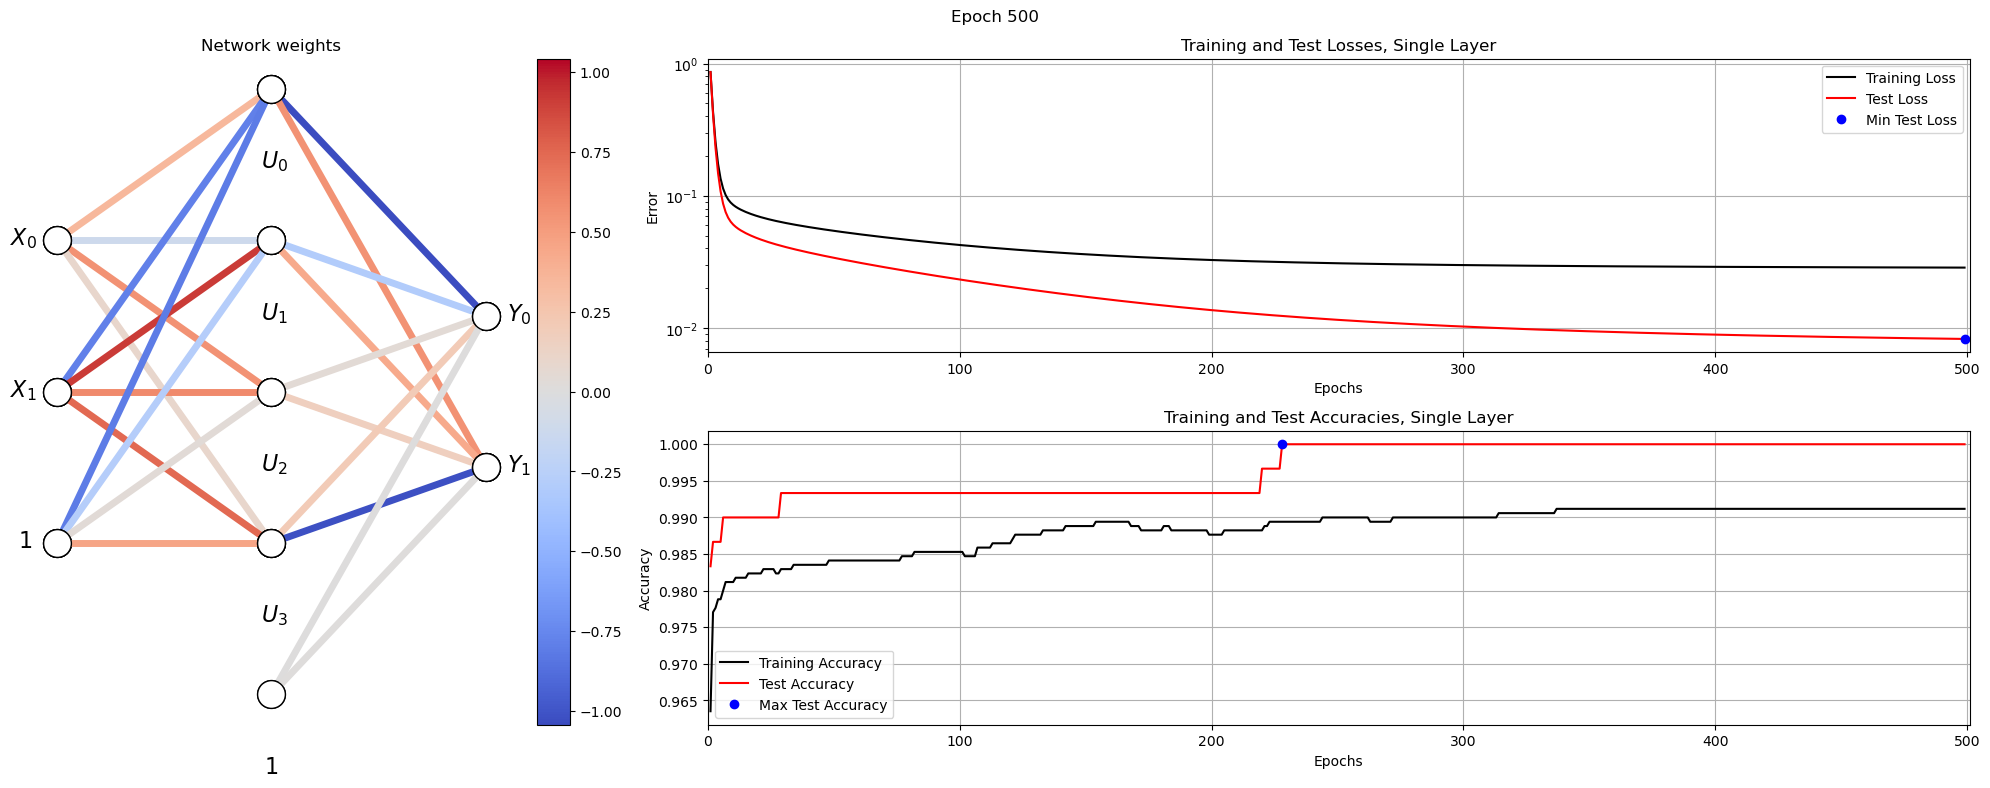

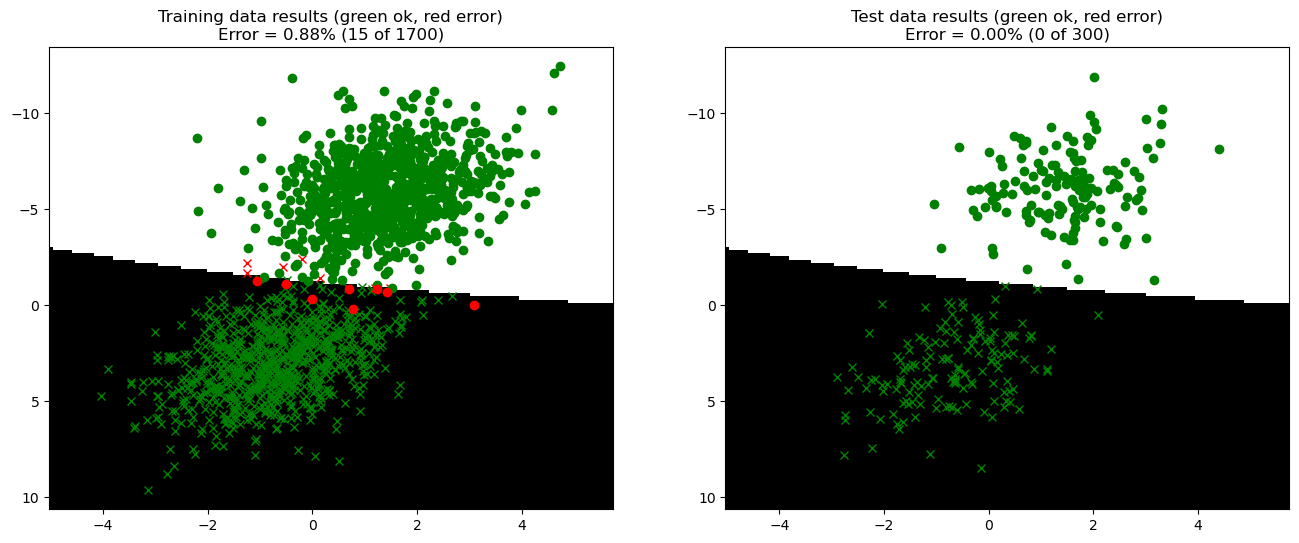

In [55]:
datasetNr = 1
splitRate = 0.15
nInputs, nClasses = getSizes(datasetNr, splitRate)
nHidden = 4
W1_0, B1_0, W2_0, B2_0 = initializeLayers(nInputs, nClasses, nHidden)
params = {"epochs": 500, "learningRate": 0.05, "normalize": False, "useTanhOutput": False, "seed": 42}
trainMultiLayerOnDataset(datasetNr, splitRate, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question:</span>**

2. Optimize the training until you reach at least 98% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

We know from working on the single layer network that the classes are easily linearly separable, so we don't need to spend too much time on selecting hyperparameters. As few as 2 hidden units can be sufficient, although we get better accuracy with 4. Looks like we need somewhat more epochs to train the network as the accuracy keeps improving even after a few hundred epochs.

#### **2.2 Optimizing dataset 2**

Train accuracy: 0.9976
Test accuracy: 1.0000
Test data confusion matrix:
[[149   0]
 [  0 151]]


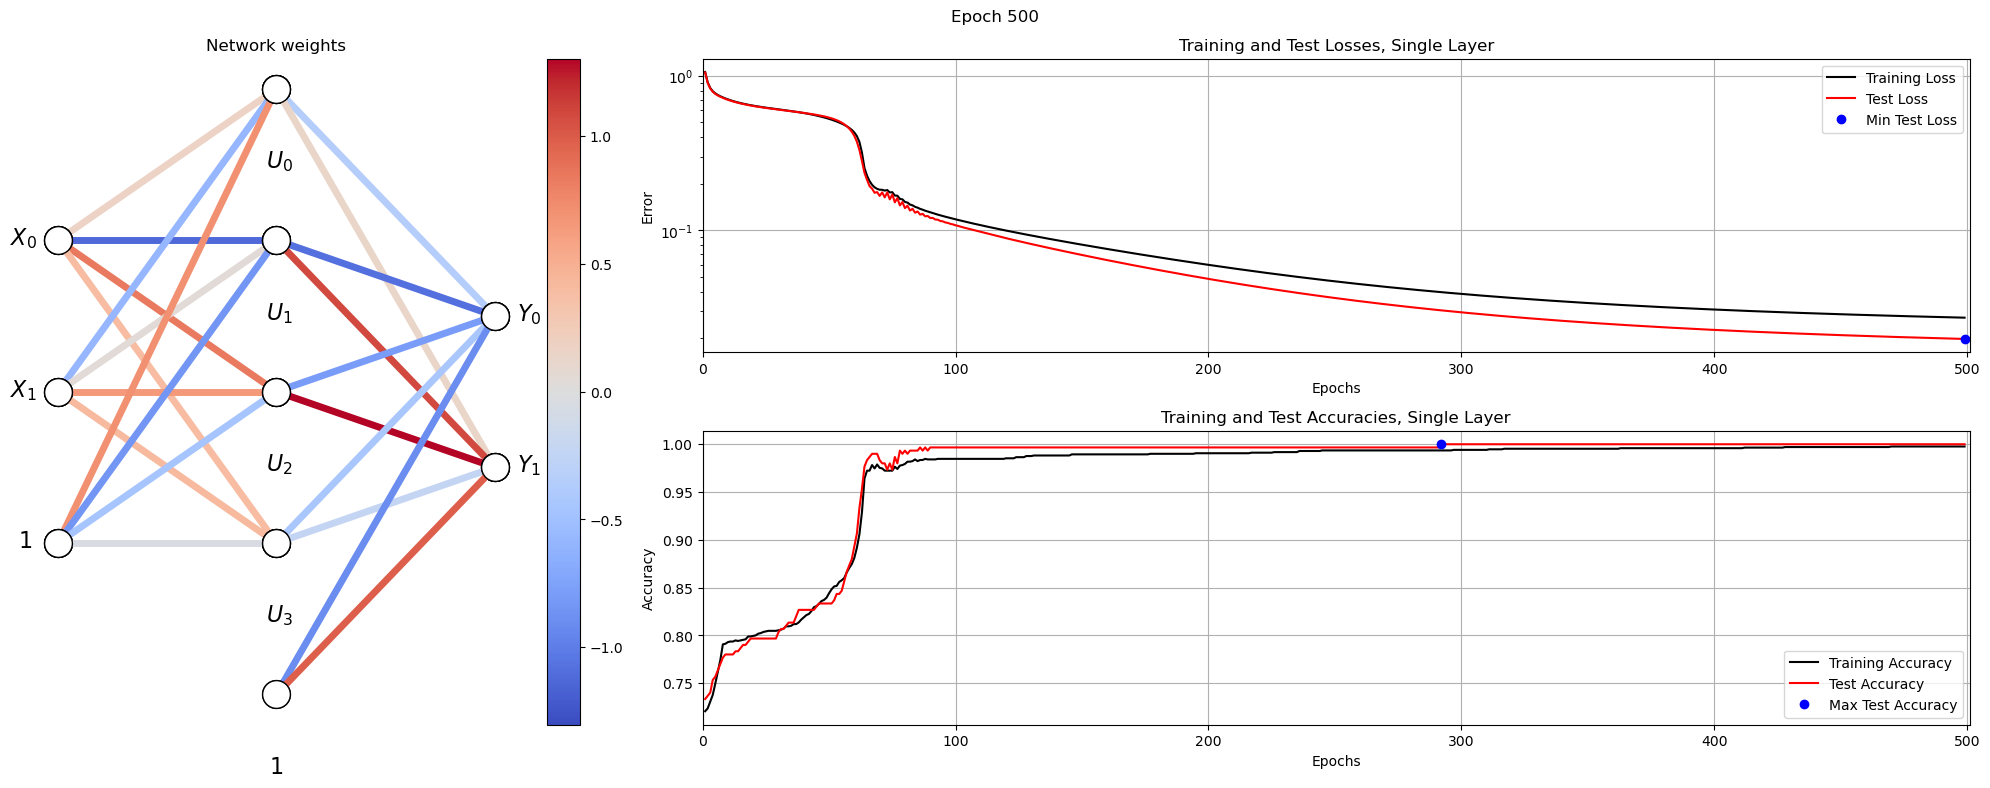

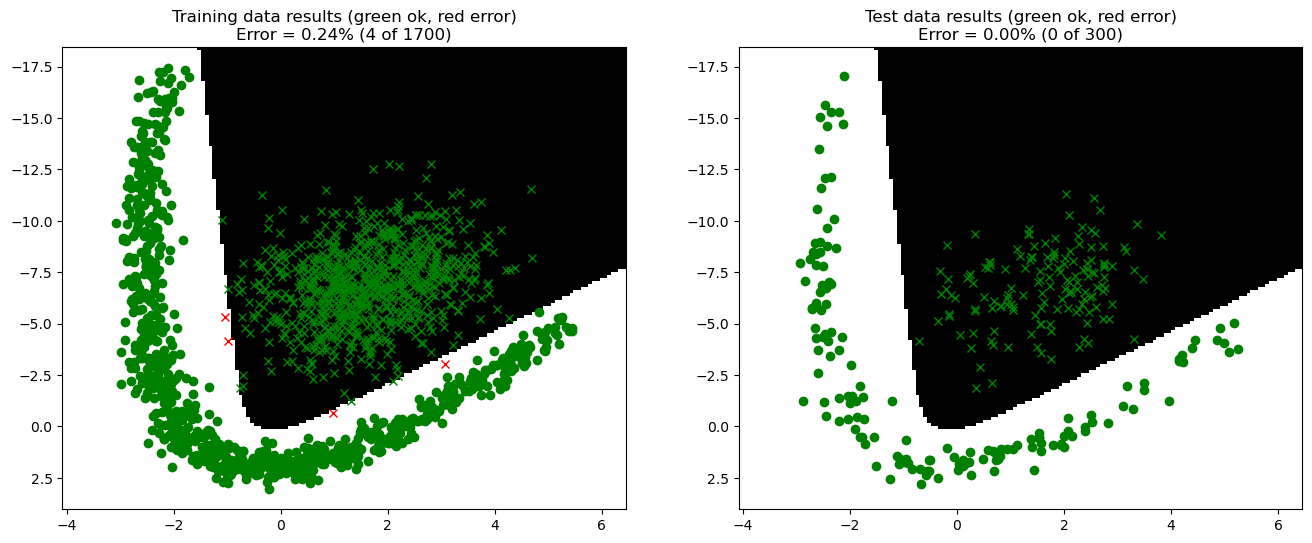

In [56]:
datasetNr = 2
splitRate = 0.15
nInputs, nClasses = getSizes(datasetNr, splitRate)
nHidden = 4
W1_0, B1_0, W2_0, B2_0 = initializeLayers(nInputs, nClasses, nHidden)
params = {"epochs": 500, "learningRate": 0.05, "normalize": False, "useTanhOutput": False, "seed": 42}
trainMultiLayerOnDataset(datasetNr, splitRate, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question:</span>**

3. Optimize the training until you reach at least 99% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

Same parameters as before seem to be sufficient to separate the two classes with a 99% test accuracy.

#### **2.3 Optimizing dataset 3**

Train accuracy: 0.9959
Test accuracy: 0.9967
Test data confusion matrix:
[[103   0   0]
 [  1  92   0]
 [  0   0 104]]


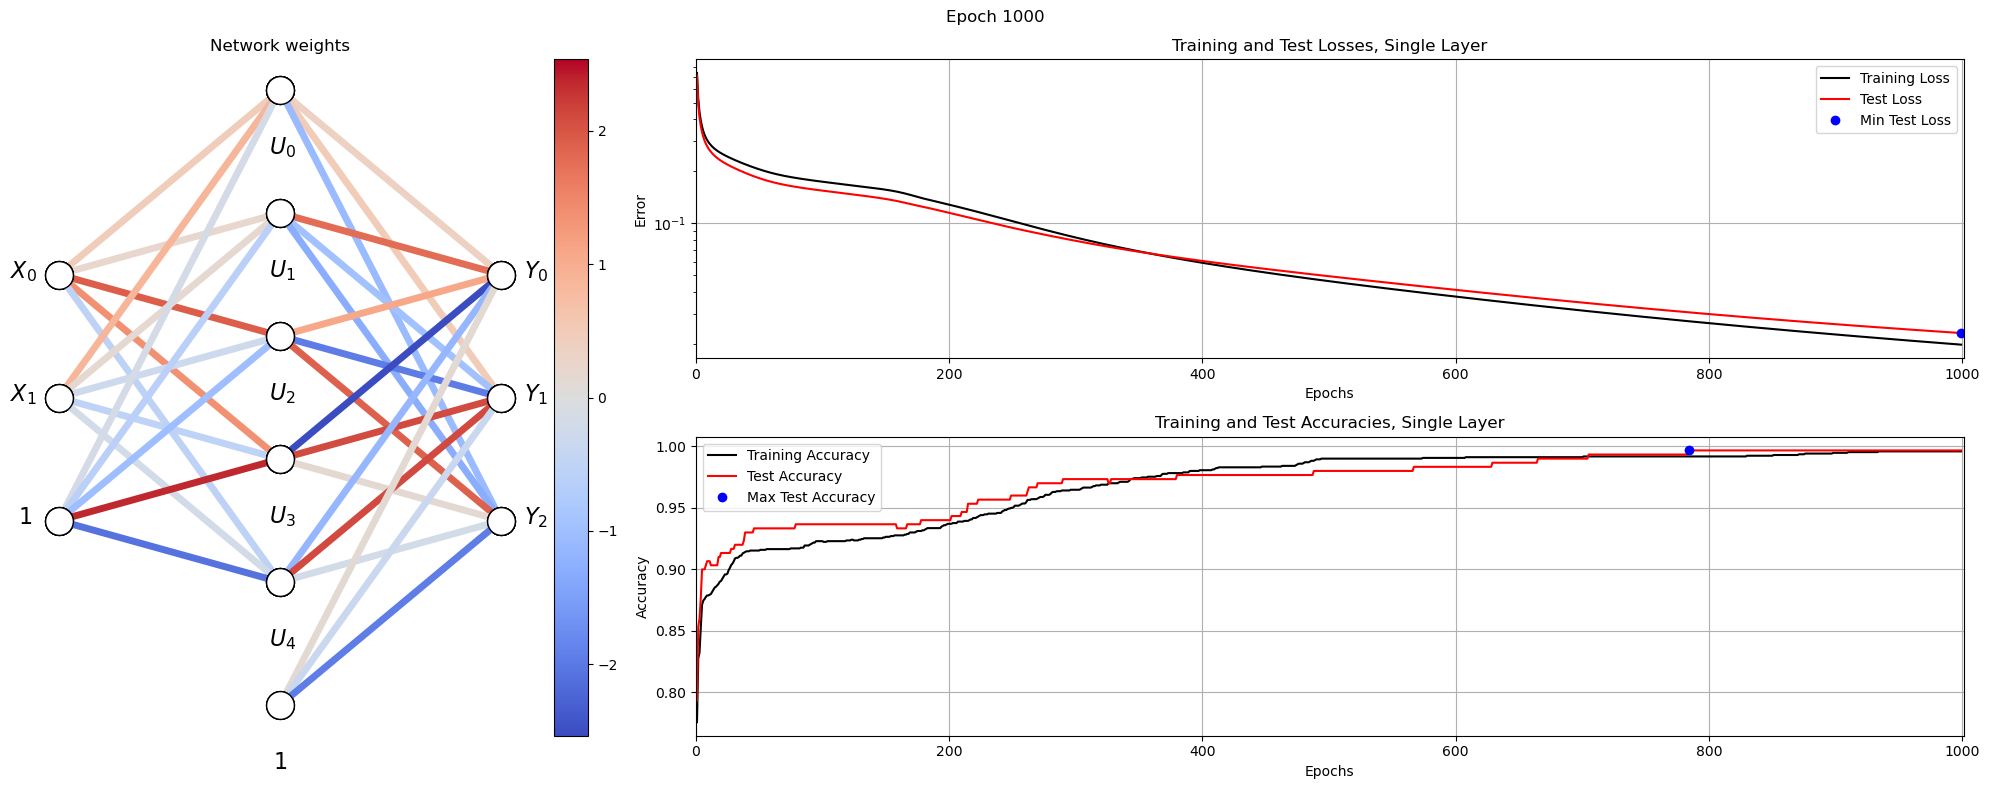

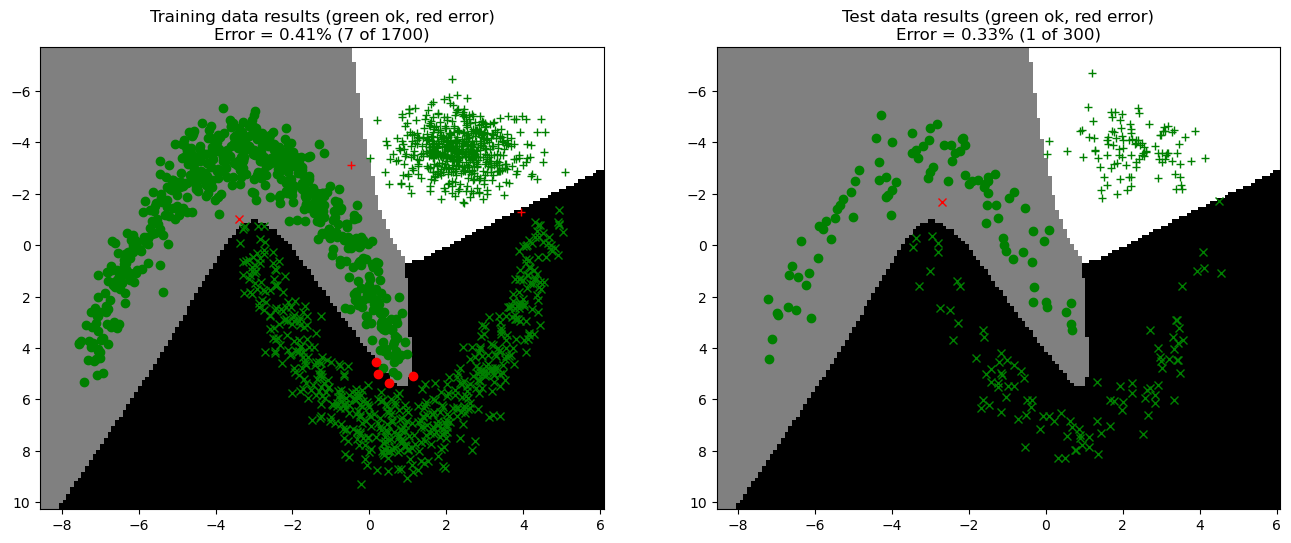

In [49]:
datasetNr = 3
splitRate = 0.15
nInputs, nClasses = getSizes(datasetNr, splitRate)
nHidden = 5
W1_0, B1_0, W2_0, B2_0 = initializeLayers(nInputs, nClasses, nHidden)
params = {"epochs": 1000, "learningRate": 0.1, "normalize": False, "useTanhOutput": True, "seed": 42}
trainMultiLayerOnDataset(datasetNr, splitRate, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question:</span>**

4. Optimize the training until you reach at least 99% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

Here it's becoming a bit difficult to come up with a good combination of parameters without a proper grid search. The number of hidden units had to be increased to 5 as it increases the curvature of the boundaries. Also, contrary to what we stated before, setting the normalize parameter to True has a noticeably negative effect on the test accuracy.

#### **2.4 Optimizing dataset 4**

Train accuracy: 0.9891
Test accuracy: 0.9656
Test data confusion matrix:
[[78  0  0  0  1  0  1  0  0  0]
 [ 0 70  0  0  0  0  0  0  1  3]
 [ 0  0 75  1  0  0  0  0  0  0]
 [ 0  0  0 87  0  1  0  0  0  0]
 [ 1  0  0  0 88  1  1  0  1  1]
 [ 0  0  0  3  0 70  0  0  1  0]
 [ 1  0  0  0  0  0 88  0  0  0]
 [ 0  0  0  0  0  0  0 99  0  0]
 [ 1  2  0  0  0  1  0  0 76  3]
 [ 0  0  1  1  0  2  0  0  0 83]]


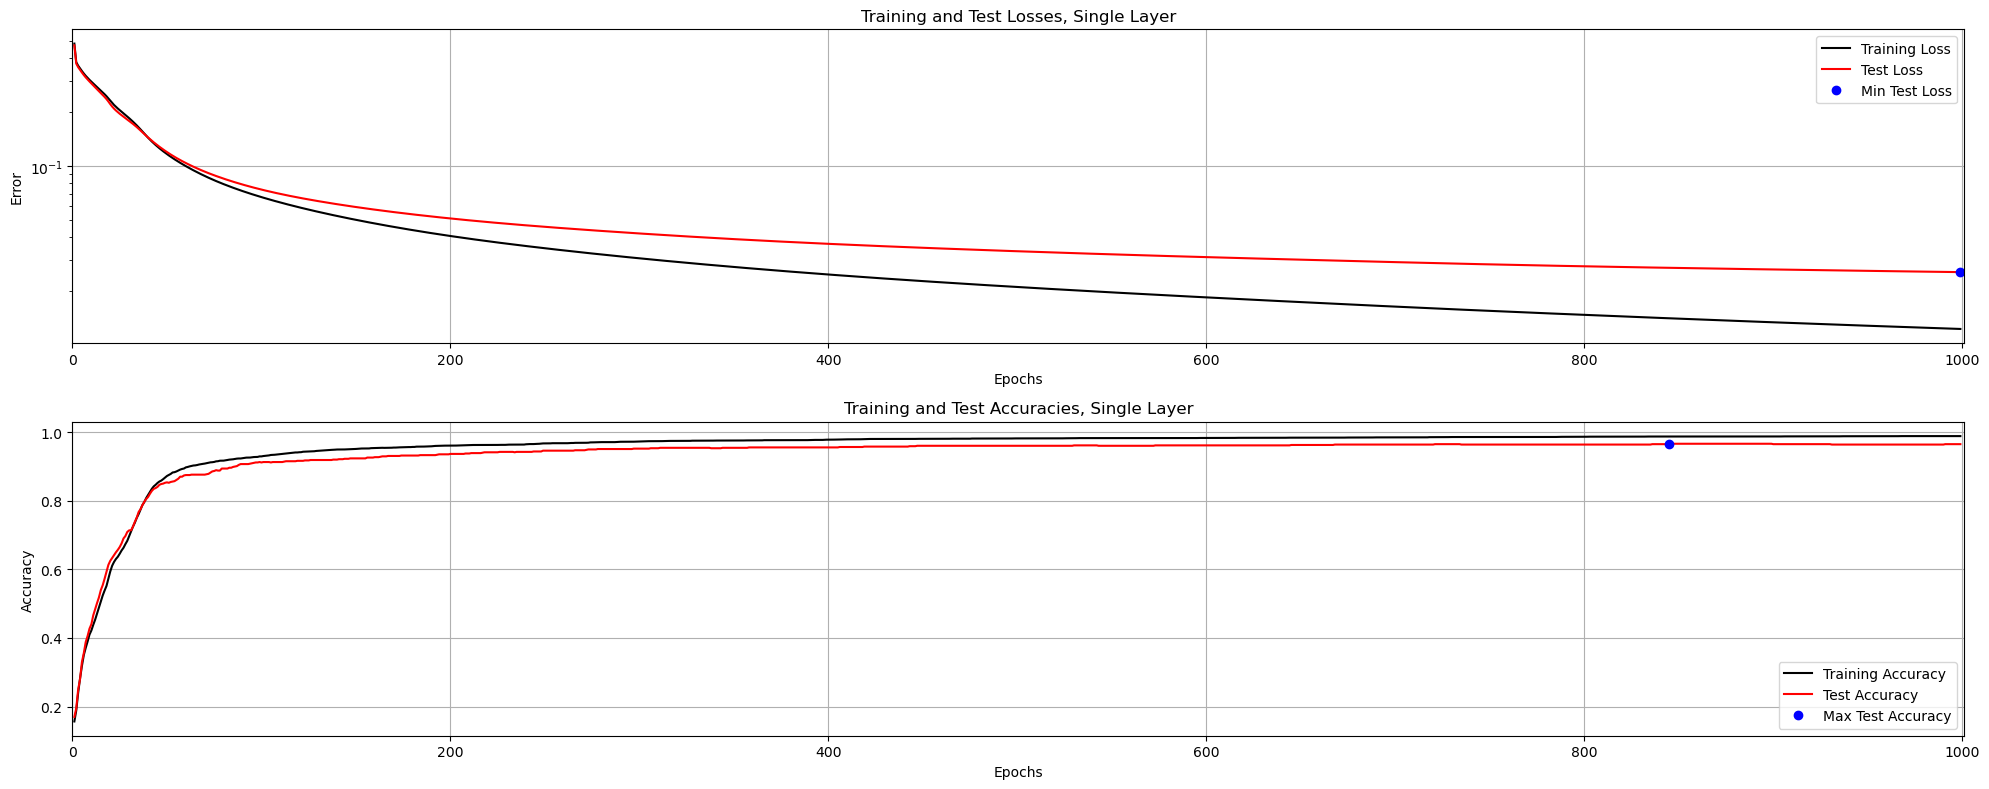

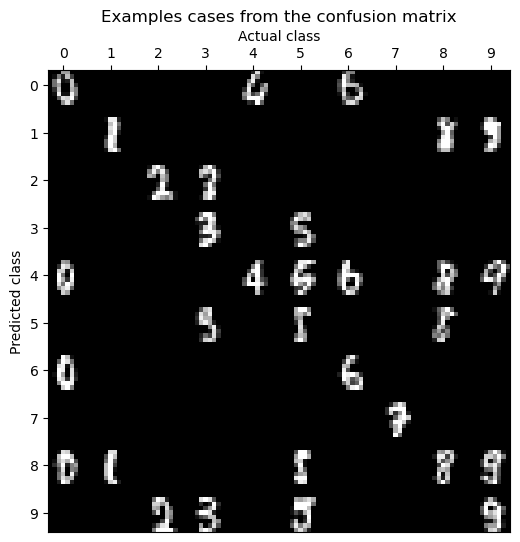

In [57]:
datasetNr = 4
splitRate = 0.15
nInputs, nClasses = getSizes(datasetNr, splitRate)
nHidden = 64
W1_0, B1_0, W2_0, B2_0 = initializeLayers(nInputs, nClasses, nHidden)
params = {"epochs": 1000, "learningRate": 0.02, "normalize": False, "useTanhOutput": True, "seed": 42}
trainMultiLayerOnDataset(datasetNr, splitRate, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question:</span>**

5. Optimize the training until you reach at least 96% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

Here we find it more beneficial to decrease the learning rate as it improved the final accuracy. The number of hidden units was found to matter significantly - if too few or too many were used, it had deleterious effects on the final test accuracy.

#### **<span style="color:green">Overall conclusion:</span>**

For the small/medium-sized classification tasks where we do not need to learn a hierarchical representation of data, we can learn a non-linear decision boundary and achieve comparable accuracy to MLPs by using kernel methods such as an RBF feature kernel.